In [430]:
##importing packages


import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import confusion_matrix , accuracy_score
import torch

In [431]:
import cv2
from torch.utils.data import Dataset, ConcatDataset ,DataLoader
import sys

array([0, 2, 3, 4, 8])

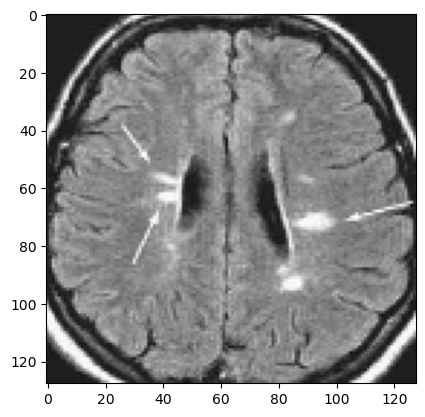

In [432]:
#Reading the images

tumor=[]
path='./archive/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img=cv2.resize(img,(128,128))
    b,g,r=cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)
    

healthy=[]
path='./archive/brain_tumor_dataset/no/*.jpg'

for f in glob.iglob(path):
    img=cv2.imread(f)
    img=cv2.resize(img,(128,128))
    b,g,r=cv2.split(img)
    img=cv2.merge([r,g,b])
    healthy.append(img)

#our images
healthy=np.array(healthy)
tumor=np.array(tumor)
All = np.concatenate((healthy,tumor))
tumor.shape

#our labels

tumor_label=np.ones(tumor.shape[0] , dtype=np.float32)
healthy_label=np.zeros(healthy.shape[0] , dtype=np.float32)


#concatenates tumor and healthy brain numpy arrays


All.shape


plt.imshow(healthy[0])

np.random.choice(10,5 , replace = False )

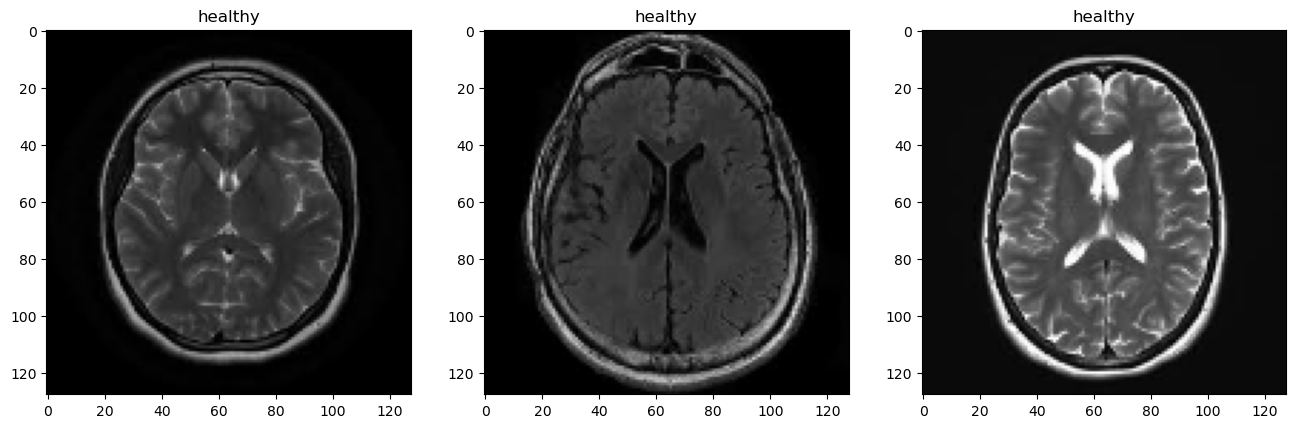

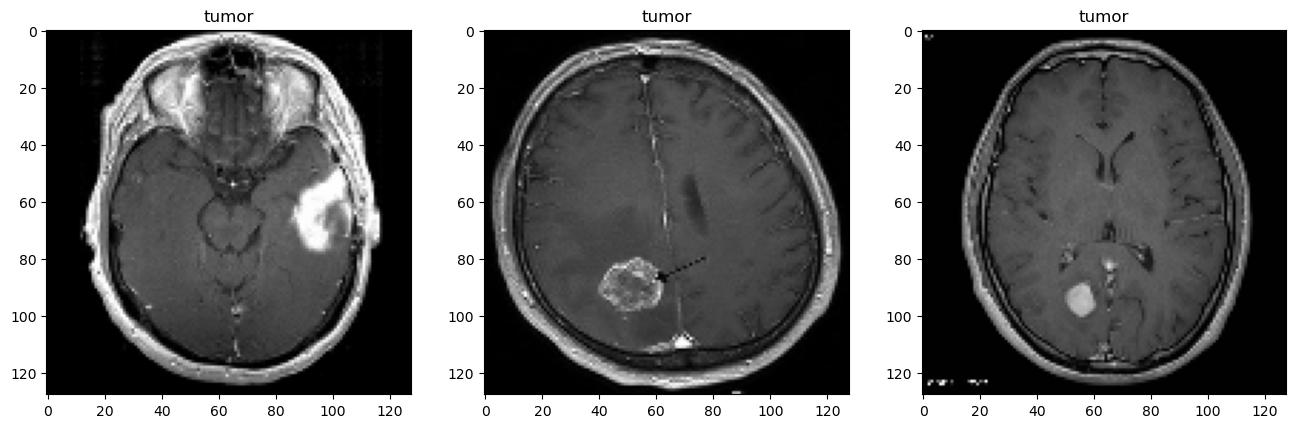

In [433]:
def plot_random(healthy , tumor , num=5):
    healthy_imgs=(healthy[np.random.choice(healthy.shape[0],num , replace = False )])
    tumor_imgs= (tumor[np.random.choice(tumor.shape[0],num , replace = False )])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        
  

plot_random(healthy,tumor,3)

In [434]:
class Dataset(object):
     def __init__(self):
         pass


     def __getitem__(self,index):
        raise NotImplementedError
     def __len__(self):
        raise NotImplementedError
     def __add__(self,other):
        return ConcatDataset([self,other])

class MRI(Dataset):
    def __init__(self):
        tumor=[]
        healthy=[]
        for f in glob.iglob("./archive/brain_tumor_dataset/yes/*.jpg"):
            img=cv2.imread(f)
            img=cv2.resize(img,(128,128))
            b,g,r=cv2.split(img)
            img=cv2.merge([r,g,b])
            img=img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            
            tumor.append(img)
        for f in glob.iglob("./archive/brain_tumor_dataset/no/*.jpg"):
            img=cv2.imread(f)
            img=cv2.resize(img,(128,128))
            b,g,r=cv2.split(img)
            img=cv2.merge([r,g,b])
            img=img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            
            healthy.append(img)
        healthy=np.array(healthy , dtype=np.float32)
        tumor=np.array(tumor , dtype=np.float32)
        

#our labels

        tumor_label=np.ones(tumor.shape[0] , dtype=np.float32)
        healthy_label=np.zeros(healthy.shape[0] , dtype=np.float32)

#concatenates tumor and healthy brain numpy arrays
        self.images=np.concatenate((tumor,healthy),axis=0)
        self.labels=np.concatenate((tumor_label,healthy_label))
         

    
        
        

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self,index):
        
        sample ={'image': self.images[index],
                'labels': self.labels[index]}
        return sample

    def normalize(self):
        self.images=self.images/255.0
    


    

In [435]:
       
       

mri=MRI()
mri.normalize()
images=mri.images
labels=mri.labels

labels.shape

len(mri)

img=mri[5]['image']

img.shape

np.max(img)

np.min(img)

##Creating A DATALOADER

##CREATE A MODEL

import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(nn.Conv2d(in_channels=3 , out_channels=6 , kernel_size=5),
                                       nn.Tanh(),nn.AvgPool2d(kernel_size=2 , stride=5),
                                       nn.Conv2d(in_channels=6 , out_channels=16 , kernel_size=(5,5)),
                                       nn.Tanh(),nn.AvgPool2d(kernel_size=2 , stride=5))
        self.fc_model=nn.Sequential(
            nn.Linear(in_features=256 , out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120 , out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84 , out_features=1))
    def forward(self,x):
        x= self.cnn_model(x)
        x=x.view(x.size(0),-1) # flattens the 2d array
        x=self.fc_model(x)
        x=F.sigmoid(x)
        return x

In [436]:
    


mri_dataset= MRI()
mri_dataset.normalize()
device = torch.device('cpu')
model=CNN().to(device)

dataloader=DataLoader(mri_dataset , batch_size=32 , shuffle=False)

In [437]:
## TRAINING THE MODEL

eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader=DataLoader(mri , batch_size=32 , shuffle=True)
model.train()

for epoch in range(1,EPOCH):
    losses=[]
    for D in dataloader:
        optimizer.zero_grad()
        data=D['image'].to(device)
        label=D['labels'].to(device) 
        y_hat=model(data)
        
        
        #define loss function
        error=nn.BCELoss()
        loss=torch.sum(error(y_hat.squeeze(),label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if(epoch+1)%10==0:
        print('Train Epoch:{}\tLoss:{:.6f}'.format(epoch+1,np.mean(losses)))
        

Train Epoch:10	Loss:0.676469
Train Epoch:20	Loss:0.611609
Train Epoch:30	Loss:0.558970
Train Epoch:40	Loss:0.564037
Train Epoch:50	Loss:0.536272
Train Epoch:60	Loss:0.498077
Train Epoch:70	Loss:0.500865
Train Epoch:80	Loss:0.449602
Train Epoch:90	Loss:0.415139
Train Epoch:100	Loss:0.393368
Train Epoch:110	Loss:0.341918
Train Epoch:120	Loss:0.347638
Train Epoch:130	Loss:0.288188
Train Epoch:140	Loss:0.264811
Train Epoch:150	Loss:0.238967
Train Epoch:160	Loss:0.210676
Train Epoch:170	Loss:0.193816
Train Epoch:180	Loss:0.165132
Train Epoch:190	Loss:0.136008
Train Epoch:200	Loss:0.111584
Train Epoch:210	Loss:0.094062
Train Epoch:220	Loss:0.074546
Train Epoch:230	Loss:0.063950
Train Epoch:240	Loss:0.045361
Train Epoch:250	Loss:0.039539
Train Epoch:260	Loss:0.028543
Train Epoch:270	Loss:0.026232
Train Epoch:280	Loss:0.019556
Train Epoch:290	Loss:0.015287
Train Epoch:300	Loss:0.012463
Train Epoch:310	Loss:0.011213
Train Epoch:320	Loss:0.009491
Train Epoch:330	Loss:0.008637
Train Epoch:340	Los

In [438]:
        
    

model.eval()

outputs=[]
y_true=[]
with torch.no_grad(): 
    for D in dataloader:
        image=D['image'].to(device)
        label=D['labels'].to(device)
        y_hat=model(image)
        outputs.append( y_hat.cpu().detach().numpy())
        y_true.append( label.cpu().detach().numpy())
outputs= np.concatenate(outputs,axis=0)
y_true=np.concatenate(y_true,axis=0)
    

def threshold(scores,threshold=0.50 , minimum=0 , maximum=1.0):
    x=np.array(list(scores))
    x[x >= threshold]= maximum
    x[x <= threshold]=minimum
    return x
    

accuracy_score(y_true , threshold(outputs))

1.0

In [451]:


import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import confusion_matrix , accuracy_score
import torch
import cv2
from torch.utils.data import Dataset, ConcatDataset ,DataLoader
import sys


In [457]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize to your model's input dimensions
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])  # Convert BGR to RGB
    img = img.astype(np.float32)  # Convert to float32
    img /= 255.0  # Normalize pixel values
    img = np.transpose(img, (2, 0, 1))  # Transpose to (channels, height, width)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = torch.from_numpy(img).float()  # Convert to tensor
    return img

image_path = './archive/brain_tumor_dataset/no/No19.jpg.jpg'
image = preprocess_image(image_path)

with torch.no_grad():
    output = model(image.to(device))
    prediction = output.item()  # Get the output value
    predicted_class = 1 if prediction >= 0.5 else 0  # Thresholding at 0.5 (adjust as needed)
    print(f"Predicted Class: {predicted_class}, Probability: {prediction:.4f}")


[ WARN:0@115702.388] global loadsave.cpp:241 findDecoder imread_('./archive/brain_tumor_dataset/no/No19.jpg.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [453]:
if (predicted_class==1):
    print("the person has brain tumor")
else:
    print("the person does not have brain tumor")

the person does not have brain tumor


##VISUALISING THE FEATURE MAPS OF THE CONVOLUTIONAL FILTERS


In [443]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [444]:
no_of_layers=0
conv_layers=[]


In [446]:
model_children=list(model.children())

In [ ]:
for child in model_children:
    if type(child)==nn.Sequential:
        for layer in child.children:
            
            